## Dynamic Circuit Constructions

In this notebook we look at examples of dynamic circuit primitives, including qubit teleportation protocols, ancillary assisted entanglement, remote CNOT applications, which can be run on IQM Garnet with Amazon Braket. 

### Notebook Setup

Before we dive into our examples, let's handle our imports. For simplicity, we will work here with standard Clifford gates, Pauli rotations, and `cc_x` or `cc_z` primitives. The `cc_x` gate (and by a simple rotation `cc_z`) applies a X gate conditionally on a particular measurement configuration.

In the local simulator, we use a composition of a partial trace and initialization procedure, which are both valid quantum channels and thus can be implemented through their Kraus operators ($\mathcal{E}[\rho]=  \sum K_i \rho K_i^\dagger$):

$$K_0= |0\rangle \langle 0 | \otimes I $$

$$ K_1 = |0 \rangle \langle 1 | \otimes X $$

Notes on `iqm_config.py` and `local_config.py`:
- `cc_x` and `cc_z` are *user defined* gate types. Use the `reset` keyword to specify an active reset. 
- These gates assume that `measure_ff` and any `cc_prx` are implemented at the same layer and time, and can be concatenated as `cc_x`.
- Importing `iqm_config.py` transpiles Clifford circuits to native IQM gates.
- For actual implementations, see the respective `iqm_config.py` or `local_config.py` files.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from braket.circuits import Circuit
from braket.experimental_capabilities import EnableExperimentalCapability
from braket.tracking import Tracker

use_qpu = True

if use_qpu: 
    import iqm_config
    qd = iqm_config.qd
else:
    import local_config
    qd = local_config.qd

track = Tracker().start()

def calc_z_exp(counts : dict, qubits : list) -> float:
    """ calculate z_expectations from shots on particular qubits """
    val = 0
    for k,v in counts.items():
        val+= v*(-1)**len([k[i] for i in qubits if k[i]=="1"])
    return val/sum(list(counts.values()))


### Teleporting Qubits

By utilizing the principle of deferred measurement with qubit swapping techniques, we can derive the following relations:

<img src="images/z_teleportation.png" alt="drawing" width="450"/>

which is referred to as Z-teleportation. Using Z-teleportation, we can shuffle a qubit through a sequence of swaps, at a potentially reduced cost over unitary swap sequences. This is implicitly used in some long-range CNOT sequences, and represents a fundamental tool in the dynamical circuit toolkit. Another fundamental tool is X-teleportation:

<img src="images/x_teleportation.png" alt="drawing" width="450"/>

which is derived by teleporting $H |\psi\rangle$ with Z-teleportation and then applying $H^\dagger= H$ after the teleportation. 

In the example here, we use X-teleportation along a list of qubits, and then show that the final target qubit state matches the input qubit state, ideally with coherences preserved. Here we will perform single-qubit tomography on the standard $Z$-basis populations of each qubit, which should only be 1 for the last qubit. 
- Note, to recover the 0 state in the ancilla, an active reset must be used. If this is not performed, we only teleport the target state, we do not preserve the 0 ancilla state.


In [2]:
qreg_total = [3, 4, 5, 2, 1]

results = []

with EnableExperimentalCapability():
    for i in range(1,len(qreg_total)+1):
        qreg = qreg_total[:i]

        circ = Circuit()
        circ.x(qreg[0])
        curr = qreg[0]
        for target in qreg[1:]:
            circ.h(target)
            circ.cnot(target,curr)
            circ.cc_x([curr, target], reset=False)
            curr = target
        
        if use_qpu: 
            circ = Circuit().add_verbatim_box(circ)
        circ.measure(qreg_total)
        results.append(qd.run(circ, shots=100).result())

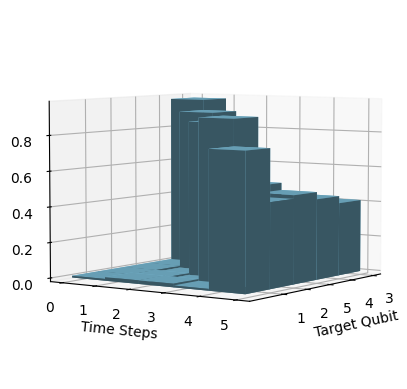

In [3]:
pops = [[calc_z_exp(res.measurement_counts, [q]) for q in range(len(qreg_total))] for res in results]

zs = -0.5*np.array(pops)+0.5*np.ones_like(pops)

xs, ys = np.meshgrid(np.arange(len(qreg_total)), np.arange(len(qreg_total)))
x,y = xs.ravel(), ys.ravel()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x,y,np.zeros_like(x),1,1, zs.ravel(),shade=True, color="skyblue",alpha=1)
ax.set_xlabel("Target Qubit")
ax.set_zlabel("Population")
ax.set_xticks(np.arange(len(qreg_total)))
ax.set_xticklabels(qreg_total)
ax.set_ylabel("Time Steps")
ax.view_init(elev=5, azim=35)
plt.show()

Despite noise on the device, we can see the state being transferred succesffuly throughout the protocol. Additionally, because we do not perform active qubit resets, the discarded qubits yield an equal statistical mixture after being used. 

### Extending CNOT Connectivity with Ancilla Qubits

Here, we look at creating entanglement using dynamical circuits for multi-qubit operations, particularly with a variant of the PARITY gate. Consider the layout on IQM Garnet: 


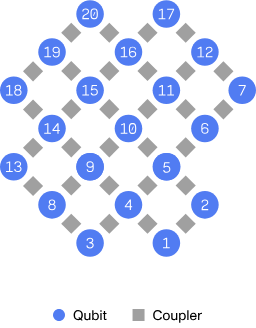

Taking qubits 2,4,6, and 10, which generally could be connected to others qubits, we can attempt to apply a limited double excitation primitive (related to a PARITY gate, but simply a $YXXX$ Pauli rotation). For four qubits there are generally straightforward ways of doing things, but disconnected qubits and limited connectivity can complicate this. Furthermore, for PARITY gates and related circuit primitives, there are [alternate decompositions](https://quantum-journal.org/papers/q-2024-12-09-1552/) which can be implemented using dynamical circuits at constant depth or limited width. 

Here, we can realize the Pauli operation by swapping the parity qubit to a joint ancilla (qubit 5) which connects all the qubits, and then swapping it back. 



In [4]:
phi = np.pi/4
para = np.random.random(1)

qreg = [2,4,6,10,5]

with EnableExperimentalCapability():
    circ = Circuit()
    circ.x(qreg[0])
    circ.x(qreg[2])

    circ.si(qreg[0])
    for q in qreg[:4]:
        circ.h(q)

    for qi in qreg[:4]:
        circ.cnot(qi, qreg[4])
    circ.rz(qreg[4],-2*phi)
    for qi in qreg[:4]:
        circ.cnot(qi, qreg[4])

    circ.cc_x([qreg[4],qreg[0]]) # single FF for maintaining coherence 

    for q in qreg[:4]:
        circ.h(q)
    circ.s(qreg[0])
    
    if use_qpu: 
        circ = Circuit().add_verbatim_box(circ)
    circ.measure(qreg[:4])
    
    res_parity = qd.run(circ, shots=500).result()

/var/folders/1_/bfh8x9qn75164y0b808mvhrh0000gq/T/ipykernel_26086/762736431.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(),size=7)


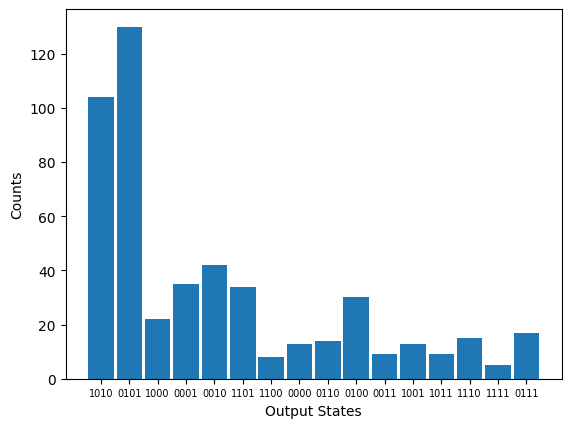

In [5]:
counts = res_parity.measurement_counts
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(list(counts.keys()), list(counts.values()),width=0.9)
ax.set_xlabel("Output States")
ax.set_ylabel("Counts")
ax.set_xticklabels(counts.keys(),size=7)
plt.show()

The dominant states here are the $1010$ and $0101$ states, which are rotated under a Pauli $YXXX$ gate. 

### Gate Teleportation for Alice and Bob

Consider Alice and Bob, each with their own qubit states. If we want to apply a remote CNOT between their states, without accessing their state directly, we can do so by sharing an intermediate entangled qubit. While there might be some limitations to the specific type which can be applied, there is a realization which exists compatible with the IQM features. Note, this follows C.2. in Appendix of [this arXiv preprint](https://arxiv.org/abs/quant-ph/0002039). 

We first prepare Alice and Bob's states. Then, Alice swaps her state with an ancilla, and uses X-teleportation to send the ancilla to Bob. Bob applies a CNOT and then teleports the circuit back using Z-teleportation. Because not all of these can be accomplished using local CNOTs, one can commute the expressions in such a way such that only a shared entangled resource is required, and the rest can be handled with dynamic circuits. 

In [6]:
qreg = [8,13,14,18]

with EnableExperimentalCapability():
    circ = Circuit()
    # alice starts of in a hadamard state Q0
    # bob is in the |1> state on Q3
    circ.h(qreg[0]).x(qreg[3])
    # generate entangled ancilla state
    circ.h(qreg[1])
    circ.cnot(qreg[1],qreg[2])

    # local entangling operations with Bob and Alice (allowed)
    circ.cnot(qreg[0],qreg[1])
    circ.cnot(qreg[2],qreg[3])
    circ.cc_x(qreg[1:])
    circ.h(qreg[2])
    circ.h(qreg[0])
    circ.cc_x([qreg[2],qreg[0]], reset=False) # reset=False avoids control error 
    circ.h(qreg[0])

    # check if there is entanglement between Alice and Bob
    print(circ)
    if use_qpu: 
        circ = Circuit().add_verbatim_box(circ)
    circ.measure([qreg[0],qreg[3]])
    res_cnot = qd.run(circ, shots=1000).result()
    print(res_cnot.measurement_counts)

T   : │         0         │         1         │       2        │         3         │         4          │  5  │          6          │         7          │          8          │          9          │       10       │
       ┌─────────────────┐  ┌──────────────┐                                                                    ┌─────────────────┐    ┌──────────────┐   ┌───────────────────┐  ┌─────────────────┐  ┌──────────────┐ 
q8  : ─┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0) ├───────────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├────┤ PRx(3.14, 0) ├───┤ 12→CCPRx(3.14, 0) ├──┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0) ├─
       └─────────────────┘  └──────────────┘                                                               │    └─────────────────┘    └──────────────┘   └───────────────────┘  └─────────────────┘  └──────────────┘ 
       ┌─────────────────┐  ┌──────────────┐                    ┌─────────────────┐   ┌──────────────┐   ┌─┴─┐   ┌───────────────┐   ┌──

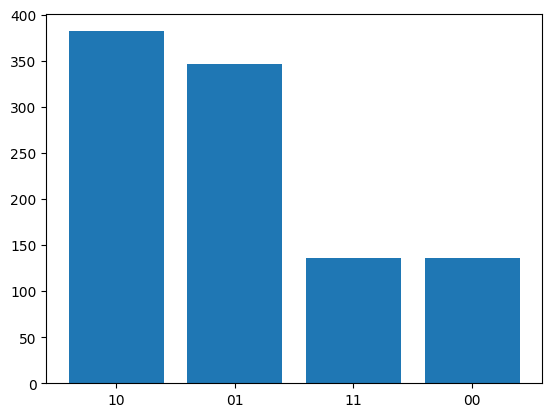

In [7]:
counts = res_cnot.measurement_counts
plt.bar(counts.keys(), counts.values())
plt.show()

#### Predicted Costs

To run these locally costs....nothing! However, you can try these out on IQM Garnet for the expected value listed in the next block. 

In [8]:
if use_qpu: 
    print("Quantum Task Summary")
    print(track.quantum_tasks_statistics())
    print(
        "\nNote: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage.\nEstimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits,\nand you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).",
    )
    print(
        f"\nEstimated cost to run this example: {track.qpu_tasks_cost() + track.simulator_tasks_cost():.3f} USD",
    )

Quantum Task Summary
{<_IQM.Garnet: 'arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet'>: {'shots': 2000, 'tasks': {'COMPLETED': 7}}}

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage.
Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits,
and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

Estimated cost to run this example: 5.000 USD


### Conclusions

In this notebook we explored basic circuit structures for dynamic circuit constructions using IQM Garnet on Amazon Braket. These represent fundamental tools for dynamic circuit generation, and allow for more complex and detailed applications. 

### References: 
1. Zhou, Leung, Chaun. *Methodology for quantum logic construction* (2000) [arXiv:0002039](https://arxiv.org/pdf/quant-ph/0002039).
2. Buhrman, Folkertsma, Loff, Nuemann. *State preparation by shallow circuits using feed forward* (2024) [Quantum 8, 1552](https://quantum-journal.org/papers/q-2024-12-09-1552/).
3. Bäumer, Tripathi, Wang, et al. *Efficient Long-Range Entanglement Using Dynamic Circuits* (2024) [PRX Quantum, 5 030339](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.5.030339).
